In [157]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

from overlapped_classes import overlapped_classes
import json
from PIL import Image
import scipy

In [158]:
with open("../mappings/objectnet_to_imagenet_1k.json") as f:
    data = json.load(f)

with open("../mappings/pytorch_to_imagenet_2012_id.json") as f:
    idxMap = json.load(f)
        
with open("../mappings/folder_to_objectnet_label.json") as f:
    folderMap = json.load(f)

with open('imagenet_classes.txt') as f:
# with open('../mappings/imagenet_to_label_2012_v2.txt') as f:    
    labels = [line.strip() for line in f.readlines()]    

In [159]:
# inverting the folderMap
dirMap = {}
for u, v in folderMap.items():
    dirMap[v]= u

In [160]:
from torchvision import models
dir(models)

# models.googlenet(pretrained=True)] #,

models_ = [ models.resnet152(pretrained=True)]



In [6]:

# model = models.alexnet(pretrained=True)
# model = models.resnet152(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.googlenet(pretrained=True)

# for model_name in models_:
#     model = eval(model_name)
#     model.eval()



In [8]:
# data

In [162]:
def predict_image_new(image_path, box, draw=False, kind='Box'):
    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transform = transforms.Compose([
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
    ])
    
    
    if kind == 'Crop':
        transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
    #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
        ])
    
    
    img = Image.open(image_path).convert("RGB")

    if kind == 'Box':
        xl, yl, xr, yr = box
        img = img.crop((xl, yl, xr, yr))   #((left, top, right, bottom)) 
        img = img.resize((224, 224))
        


    img_t = transform(img).float()

    if draw:
        plt.imshow(img) #img_t.permute((2,1,0)) )
        plt.show()

    image_tensor = img_t.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Predict the class of the image
    output = model(image_tensor)
    
    confs, indices = torch.sort(output.data, descending=True)
    confs[0] = confs[0]/sum(confs[0])
    return np.abs(confs[0][:5]), indices[0][:5], img  # index

In [24]:
# list(data)
list(data.keys())[0:10]

['Alarm clock',
 'Backpack',
 'Banana',
 'Band Aid',
 'Basket',
 'Bath towel',
 'Beer bottle',
 'Bench',
 'Bicycle',
 'Binder (closed)']

In [198]:


for model in models_:
    model_name = model._get_name() #eval(model_name)
    model.eval()

    print(model_name + '\n')
    
    res_top1 = []

#     data = {''}
    
    for n, category in enumerate(['Sunglasses']): #  list(data.keys())[2:3]): # choose the in

        txtfile = '../Annotations/' + dirMap[category] + '.txt'
        if not os.path.exists(txtfile):
            continue

        with open(txtfile) as f:
            boxes = [line.strip() for line in f.readlines()]    


        confs_pred = []
        confs_pred_wrong = []        
        lines = 0
        count = 0
        for im in boxes:
            ss = im.split(' ')
            fName = ss[0]
            if len(ss) > 1:
                lines += 1
                coords = (int(i) for i in ss[1:] if i)
                confs, idx, im  = predict_image_new(os.path.join('../images/' + dirMap[category] + '/', fName), coords, False, kind='Box')

                # top 1
                if labels[idx[0]] in data[category]:
                    count += 1 
                    confs_pred.append((data[category], labels[idx[0]], im, float(confs[0])))
                else:
                    confs_pred_wrong.append((data[category], labels[idx[0]], im, float(confs[0])))
                    

#                 ff.write(f"{fName} {int(idx[0])} {int(idx[1])} {int(idx[2])} {int(idx[3])} {int(idx[4])}           {confs[0]:.2f} {confs[1]:.2f} {confs[2]:.2f} {confs[3]:.2f} {confs[4]:.2f} \n")


        confs

        accs = np.array(count)*100/lines

        print(f"{n} -> {category}: top 1: {accs:.2f}   [num imgs: {lines}]")  

        res_top1.append(accs)        

    print(sum(res_top1)/len(res_top1))


ResNet

0 -> Sunglasses: top 1: 61.62   [num imgs: 185]
61.62162162162162


## Run the following to see correct predictions

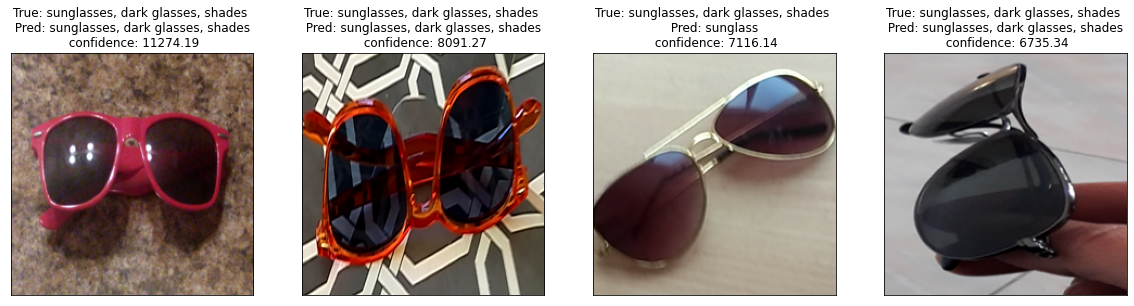

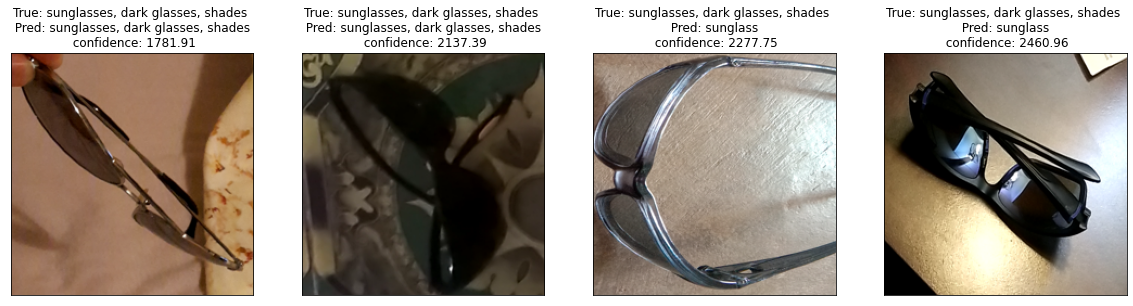

In [199]:
scores = sorted(confs_pred, key= lambda x:x[3]) 

# top 4 correct high confidence predictions
fig, axs = plt.subplots(1,4, figsize=(20,20))

for i in range(4):
    axs[i].imshow(scores[~i][2])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title( f'True: {scores[~i][0][:40]} \n Pred: {scores[~i][1][:40]} \n confidence: {scores[~i][3]:.2f}')

plt.show()
fig.tight_layout()
fig.savefig('../figs/samples/' + category + '-  correct-good.png')

# top 4 correct low confidence predictions
fig, axs = plt.subplots(1,4, figsize=(20,20))

for i in range(4):
    axs[i].imshow(scores[i][2])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title( f'True: {scores[i][0][:40]} \n Pred: {scores[i][1][:40]} \n confidence: {scores[i][3]:.2f}')

plt.show()
fig.tight_layout()
fig.savefig('../figs/samples/' + category + '-  correct-bad.png')    
    

In [172]:
!pwd

/Users/ali/Desktop/objectnet-1.0/code


## Run the following to see false predictions

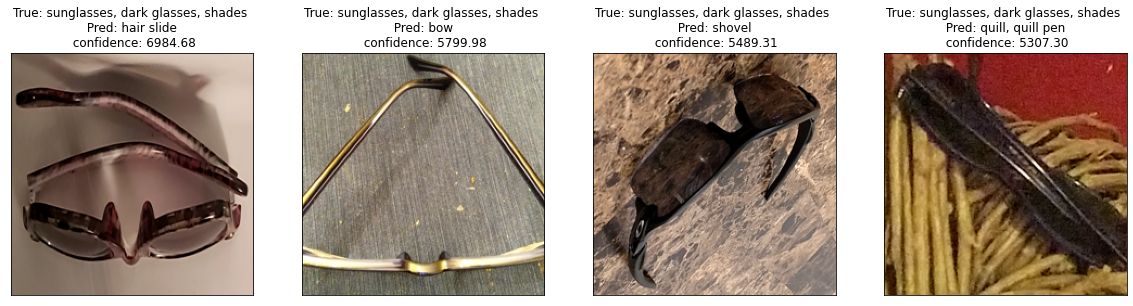

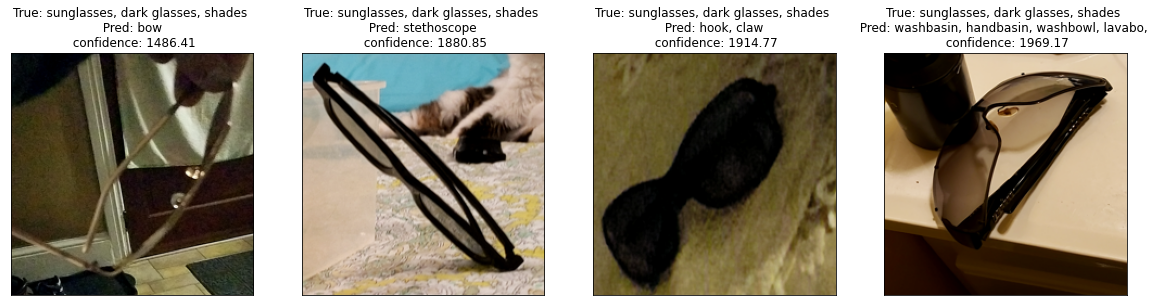

In [200]:
scores = sorted(confs_pred_wrong, key= lambda x: x[3]) 

# top 4 false high confidence predictions
fig, axs = plt.subplots(1,4, figsize=(20,20))

for i in range(4):
    axs[i].imshow(scores[~i][2])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title( f'True: {scores[~i][0][:40]} \n Pred: {scores[~i][1][:40]} \n confidence: {scores[~i][3]:.2f}')

plt.show()
fig.tight_layout()
fig.savefig('../figs/samples/' + category + '-  wrong-bad.png')

# top 4 false low confidence predictions
fig, axs = plt.subplots(1,4, figsize=(20,20))

for i in range(4):
    axs[i].imshow(scores[i][2])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title( f'True: {scores[i][0][:40]} \n Pred: {scores[i][1][:40]} \n confidence: {scores[i][3]:.2f}')

plt.show()
fig.tight_layout()
fig.savefig('../figs/samples/' + category + '-  wrong-good.png')    
    
    

In [118]:
confs_pred

[('plate',
  'plate',
  <PIL.Image.Image image mode=RGB size=224x224 at 0x1411A8850>,
  3425.91015625),
 ('plate',
  'plate',
  <PIL.Image.Image image mode=RGB size=224x224 at 0x13D4348D0>,
  3313.0693359375)]

In [155]:
# boxes